In [2]:
# Preliminaries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import math 

import pandas as pd 
import matplotlib
import matplotlib.pylab as plt 
import seaborn as sns 
import numpy as np
from math import *
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
from matplotlib.patches import Ellipse
%matplotlib inline
from scipy.stats import linregress
from matplotlib.offsetbox import AnchoredText

In [3]:
# Load the data
g1 = nx.read_graphml('../../fep-maps/graphml/CDK2_Blake_samegraph_051118_out.graphml')
g2 = nx.read_graphml('../../fep-maps/graphml/ERK2_Blake_samegraph_051118_out.graphml')
list_of_graphs = [g1, g2]
g1.remove_node('9')
g2.remove_node('9')

In [4]:
nedges = len(g1.edges)
nligands = len(g1.nodes)
print(nedges)
G_to_DeltaG = np.zeros([nedges, nligands])
DeltaG_BAR_target1_complex_calc = np.zeros([nedges])
dDeltaG_BAR_target1_complex_calc = np.zeros([nedges])
DeltaG_BAR_target1_solvent_calc = np.zeros([nedges])
dDeltaG_BAR_target1_solvent_calc = np.zeros([nedges])
DeltaDeltaG_exp_target1 = np.zeros([nedges])
DeltaDeltaG_CycleClosure_ij_target1 = np.zeros([nedges])
DeltaDeltaG_CycleClosure_ij_target2 = np.zeros([nedges])
for edge_index, edge in enumerate(g1.edges):
    DeltaG_BAR_target1_complex_calc[edge_index] = g1.edges[edge]['complex_dg_val']
    dDeltaG_BAR_target1_complex_calc[edge_index] = g1.edges[edge]['complex_dg_unc']
    DeltaG_BAR_target1_solvent_calc[edge_index] = g1.edges[edge]['solvent_dg_val']
    dDeltaG_BAR_target1_solvent_calc[edge_index] = g1.edges[edge]['solvent_dg_unc']
    DeltaDeltaG_exp_target1[edge_index] = g1.edges[edge]['exp_ddg']
    DeltaDeltaG_CycleClosure_ij_target1[edge_index] = g1.edges[edge]['ccc_ddg_val']


DeltaG_BAR_target2_complex_calc = np.zeros([nedges])
dDeltaG_BAR_target2_complex_calc = np.zeros([nedges])
DeltaG_BAR_target2_solvent_calc = np.zeros([nedges])
dDeltaG_BAR_target2_solvent_calc = np.zeros([nedges])
DeltaDeltaG_exp_target2 = np.zeros([nedges])
for edge_index, edge in enumerate(g2.edges):
    ligand_i, ligand_j = edge
    DeltaG_BAR_target2_complex_calc[edge_index] = g2.edges[edge]['complex_dg_val']
    dDeltaG_BAR_target2_complex_calc[edge_index] = g2.edges[edge]['complex_dg_unc']
    DeltaG_BAR_target2_solvent_calc[edge_index] = g2.edges[edge]['solvent_dg_val']
    dDeltaG_BAR_target2_solvent_calc[edge_index] = g2.edges[edge]['solvent_dg_unc']
    DeltaDeltaG_exp_target2[edge_index] = g2.edges[edge]['exp_ddg']
    DeltaDeltaG_CycleClosure_ij_target2[edge_index] = g2.edges[edge]['ccc_ddg_val']

DeltaG_exp_1 = np.zeros([nligands])
DeltaG_CC_1 = np.zeros([nligands])
dDeltaG_CC_1 = np.zeros([nligands])
for node_index,node in enumerate(g1.nodes):
    DeltaG_exp_1[node_index] = g1.nodes[node]['exp_dg']
    DeltaG_CC_1[node_index] = g1.nodes[node]['pred_dg_val']
    dDeltaG_CC_1[node_index] = g1.nodes[node]['pred_dg_unc']

DeltaG_CC_2 = np.zeros([nligands])
dDeltaG_CC_2 = np.zeros([nligands])
DeltaG_exp_2 = np.zeros([nligands])
for node_index,node in enumerate(g2.nodes):
    DeltaG_exp_2[node_index] = g2.nodes[node]['exp_dg']
    DeltaG_CC_2[node_index] = g2.nodes[node]['pred_dg_val']
    dDeltaG_CC_2[node_index] = g2.nodes[node]['pred_dg_unc']

selectivity_pred_set1 = DeltaG_CC_2 - DeltaG_CC_1
selectivity_exp_set1 = DeltaG_exp_2 - DeltaG_exp_1
selectivity_pred_unc_set1 = np.sqrt(dDeltaG_CC_1 ** 2 + dDeltaG_CC_2 ** 2)

25


In [5]:
error_experiment = []
nsamples = nligands
for x in range(nsamples): 
    error_experiment.append(0.3)
error_experiment = np.asarray(error_experiment)

mue_selectivity = []
rmse_selectivity = []
mue_1 = []
rmse_1 = []
mue_2 = []
rmse_2 = []
r_values = []


nreplicates = 10000
for replicate in range(nreplicates):
    # bootstrapping over the indices 
    samples = np.random.choice(np.arange(nsamples), nsamples)
    
    # generating bootstrapped replicates
    exp_replicate_1 = DeltaG_exp_1[samples] 
    pred_replicate_1 = DeltaG_CC_1[samples]
    exp_replicate_2 = DeltaG_exp_2[samples] 
    pred_replicate_2 = DeltaG_CC_2[samples]

    offset_1 = (exp_replicate_1.mean() - pred_replicate_1.mean()) # calculating the offset used for converting to dG 
    pred_replicate_1 = pred_replicate_1 + offset_1 # shifting the predicted replicates by the offset 
    
    offset_2 = (exp_replicate_2.mean() - pred_replicate_2.mean()) # calculating the offset used for converting to dG 
    pred_replicate_2 = pred_replicate_2 + offset_2 # shifting the predicted replicates by the offset 
    
    # Calculate predicted selectivity 
    selectivity_experiment = exp_replicate_2 - exp_replicate_1
    selectivity_predicted = pred_replicate_2 - pred_replicate_1
    
    
    # calculate bootstrapped statistics for selectivity
    rmse_selectivity_val = mean_squared_error(selectivity_experiment, selectivity_predicted) 
    mue_selectivity_val = mean_absolute_error(selectivity_experiment, selectivity_predicted)
    mue_selectivity.append(mue_selectivity_val)
    rmse_selectivity.append(rmse_selectivity_val)
    
    # calculate bootstrapped statistics for target 1
    rmse_1_val = mean_squared_error(exp_replicate_1, pred_replicate_1) 
    mue_1_val = mean_absolute_error(exp_replicate_1, pred_replicate_1)
    mue_1.append(mue_1_val)
    rmse_1.append(rmse_1_val)
    
    # calculate bootstrapped statistics for target 1
    rmse_2_val = mean_squared_error(exp_replicate_2, pred_replicate_2) 
    mue_2_val = mean_absolute_error(exp_replicate_2, pred_replicate_2)
    mue_2.append(mue_2_val)
    rmse_2.append(rmse_2_val)
    
    # R values 
    error_target1 = exp_replicate_1 - pred_replicate_1
    error_target2 = exp_replicate_2 - pred_replicate_2
    slope, intercept, r_value, p_value, std_err = linregress(error_target2, error_target1)
    r_values.append(r_value)
    
    

In [6]:
np.percentile(rmse_selectivity, [2.5, 97.5])

array([0.22395872, 1.3759235 ])

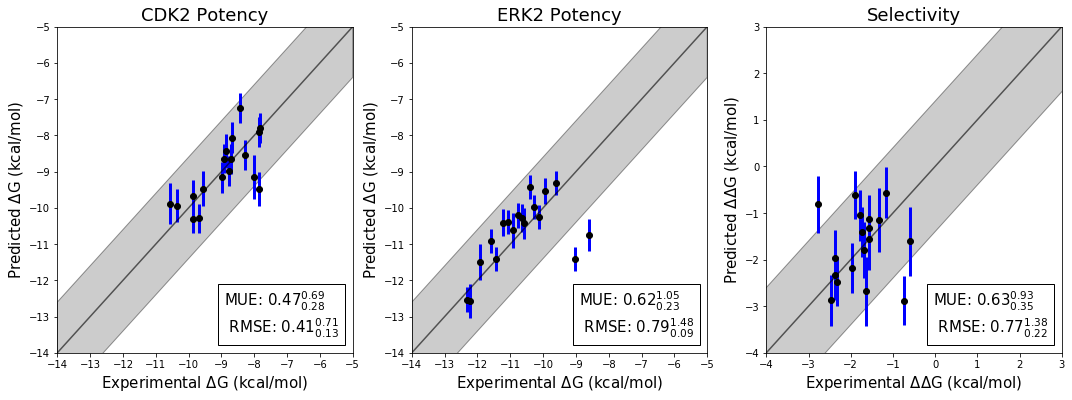

In [7]:
fig = plt.figure(figsize=(18,6))
x = np.array(range(-14, -4))
y = np.array(range(-14, -4))
ax = fig.add_subplot(1,3,1)
x_points = DeltaG_exp_1
y_points = DeltaG_CC_1
yerr = dDeltaG_CC_1
RMSE = mean_squared_error(x_points, y_points)
MUE = mean_absolute_error(x_points, y_points)
text = AnchoredText('MUE: $%.2f^{%.2f}_{%.2f}$ \n RMSE: $%.2f^{%.2f}_{%.2f}$' % (MUE, 
                                                                                 np.percentile(mue_1, [2.5, 97.5])[1], 
                                                                                 np.percentile(mue_1, [2.5, 97.5])[0], 
                                                                                 RMSE, 
                                                                                 np.percentile(rmse_1, [2.5, 97.5])[1], 
                                                                                 np.percentile(rmse_1, [2.5, 97.5])[0]), 
                    loc=4, prop=dict(fontsize=15))
ax.plot(x,y, ls="-", c="black", alpha=.6)
ax.fill_between(x, y - 1.4, y+1.4, facecolor='gray', edgecolor='black', alpha=.4, linewidth=1)
# for point in range(len(x_points)):
#     e = Ellipse(xy=(x_points[point],y_points[point]), width=0.3, height=yerr[point])
#     ax.add_artist(e)
#     e.set_facecolor('blue')
#     e.set_alpha(.3)
#     e.set_edgecolor('blue')
#ax.errorbar(x_points, y_points, xerr=0.3, yerr=np.sqrt(yerr**2 + 0.9 **2), fmt='o', c='black', ecolor='blue', alpha=.6)
ax.errorbar(x_points, y_points, yerr=yerr*1.96, fmt='o', c='black', ecolor='blue',elinewidth=3)
ax.add_artist(text)
ax.set_title('CDK2 Potency', fontsize=18)
plt.ylim(-14,-5)
plt.xlim(-14,-5)
plt.xlabel('Experimental $\Delta$G (kcal/mol)', fontsize=15)
plt.ylabel('Predicted $\Delta$G (kcal/mol)', fontsize=15)


ax = fig.add_subplot(1,3,2)
x = np.array(range(-14, -4))
y = np.array(range(-14, -4))
x_points = DeltaG_exp_2
y_points = DeltaG_CC_2
yerr = dDeltaG_CC_2
RMSE = mean_squared_error(x_points, y_points)
MUE = mean_absolute_error(x_points, y_points)
text = AnchoredText('MUE: $%.2f^{%.2f}_{%.2f}$ \n RMSE: $%.2f^{%.2f}_{%.2f}$' % (MUE, 
                                                                                 np.percentile(mue_2, [2.5, 97.5])[1], 
                                                                                 np.percentile(mue_2, [2.5, 97.5])[0], 
                                                                                 RMSE, 
                                                                                 np.percentile(rmse_2, [2.5, 97.5])[1], 
                                                                                 np.percentile(rmse_2, [2.5, 97.5])[0]), 
                    loc=4, prop=dict(fontsize=15))
ax.plot(x,y, ls="-", c="black", alpha=.6)
ax.fill_between(x, y - 1.4, y+1.4, facecolor='gray', edgecolor='black', alpha=.4, linewidth=1)
# for point in range(len(x_points)):
#     e = Ellipse(xy=(x_points[point],y_points[point]), width=0.3, height=yerr[point])
#     ax.add_artist(e)
#     e.set_facecolor('blue')
#     e.set_alpha(.3)
#     e.set_edgecolor('blue')
#ax.errorbar(x_points, y_points, xerr=0.3, yerr=np.sqrt(yerr**2 + 0.9 **2), fmt='o', c='black', ecolor='blue', alpha=.6)
ax.errorbar(x_points, y_points, yerr=yerr*1.96, fmt='o', c='black', ecolor='blue',elinewidth=3)
ax.add_artist(text)
ax.set_title('ERK2 Potency', fontsize=18)
plt.ylim(-14,-5)
plt.xlim(-14,-5)
plt.xlabel('Experimental $\Delta$G (kcal/mol)', fontsize=15)
plt.ylabel('Predicted $\Delta$G (kcal/mol)', fontsize=15)


ax = fig.add_subplot(1,3,3)
x = np.array(range(-6, 8))
y = np.array(range(-6, 8))
ax.plot(x,y, ls="-", c="black", alpha=.6)
ax.fill_between(x, y - 1.4, y+1.4, facecolor='gray', edgecolor='black', alpha=.4, linewidth=1)
x_points = selectivity_exp_set1
y_points = selectivity_pred_set1
yerr = selectivity_pred_unc_set1
RMSE = mean_squared_error(x_points, y_points)
MUE = mean_absolute_error(x_points, y_points)
text = AnchoredText('MUE: $%.2f^{%.2f}_{%.2f}$ \n RMSE: $%.2f^{%.2f}_{%.2f}$' % (MUE, 
                                                                                 np.percentile(mue_selectivity, [2.5, 97.5])[1], 
                                                                                 np.percentile(mue_selectivity, [2.5, 97.5])[0], 
                                                                                 RMSE, 
                                                                                 np.percentile(rmse_selectivity, [2.5, 97.5])[1], 
                                                                                 np.percentile(rmse_selectivity, [2.5, 97.5])[0]), loc=4, prop=dict(fontsize=15))
# for point in range(len(x_points)):
#     e = Ellipse(xy=(x_points[point],y_points[point]), width=2*0.42, height=2*yerr[point])
#     ax.add_artist(e)
#     e.set_facecolor('blue')
#     e.set_alpha(.3)
#     e.set_edgecolor('blue')
#ax.errorbar(x_points, y_points, xerr=0.42, yerr=np.sqrt(yerr**2 + 0.9 **2), fmt='o', c='black', ecolor='blue', alpha=.6)
ax.errorbar(x_points, y_points, yerr=yerr*1.96, fmt='o', c='black', ecolor='blue',elinewidth=3)
ax.add_artist(text)
plt.xlabel('Experimental $\Delta$$\Delta$G (kcal/mol)', fontsize=15)
plt.ylabel('Predicted $\Delta$$\Delta$G (kcal/mol)', fontsize=15)
ax.set_title('Selectivity', fontsize=18)
plt.ylim(-4,3)
plt.xlim(-4,3)

fig.savefig('cdk2_erk2_replicate1.pdf', dpi=500, bbox_inches='tight')
